# Linear regression

In [1]:
# Import pkgs
using Turing, Distributions, RDatasets, MCMCChains, Plots, StatsPlots, MLDataUtils, Distances, Random
Random.seed!(0)

TaskLocalRNG()

In [2]:
# Import the "Default dataset"
data= RDatasets.dataset("datasets", "mtcars");

# Show first 6 rows
first(data, 6);
typeof(data)


DataFrame

In [3]:
# Some data cleaning
# Remove the model column
select!(data, Not(:Model))

# Split the data 70-30 into trainig/test sets
trainset, testset= MLDataUtils.splitobs(MLDataUtils.shuffleobs(data), 0.7)

# Turing requires data in matrix form
target= :MPG
train= Matrix(select(trainset, Not(target)))
test= Matrix(select(testset, Not(target)))
train_target= trainset[:, target]
test_target= testset[:, target]

# Standarize the features
μ, σ= MLDataUtils.rescale!(train; obsdim=1)
MLDataUtils.rescale!(test, μ, σ; obsdim=1)

# Standarize the tartgets
μtargets, σtargets= MLDataUtils.rescale!(train_target; obsdim=1)
MLDataUtils.rescale!(test_target, μtargets, σtargets; obsdim=1)

(19.927272727272726, 5.1987344447317)

In [4]:
# Model specification

# Bayesina linear regression
@model function lin_reg(x,y)
    # Set variance prior
    σ₂~ Distributions.truncated(Normal(0,100), 0, Inf)
    
    # Set intercept prior
    α~ Normal(0, sqrt(3))
    
    # Set coefficients priors
    nfeatures= size(x,2)
    coeff~ Distributions.MvNormal(nfeatures, sqrt(10))
    
    # Estimate all the mu terms
    mu= α.+ x* coeff
    y~ Turing.MvNormal(mu, sqrt(σ₂))
end

lin_reg (generic function with 2 methods)

In [5]:
model= lin_reg(train, train_target)
chain= Turing.sample(model, NUTS(0.65), 3000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/doppelganger/.julia/packages/Turing/QRn5N/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (3000×24×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 14.67 seconds
Compute duration  = 14.67 seconds
parameters        = σ₂, α, coeff[1], coeff[2], coeff[3], coeff[4], coeff[5], coeff[6], coeff[7], coeff[8], coeff[9], coeff[10]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          σ₂    0.4578    0.2479     0.0045    0.0072   1010.3536    0.9997    ⋯
           α   -0.0009    0.1377     0.0025    0.0028   2597.8287    1.0005    ⋯
    coeff[1]   -0.5180    0.5922     0.0108    0.0132   2091.5528    1.0006    ⋯
    coeff[2]    0.3255    0.7828     0.0143   

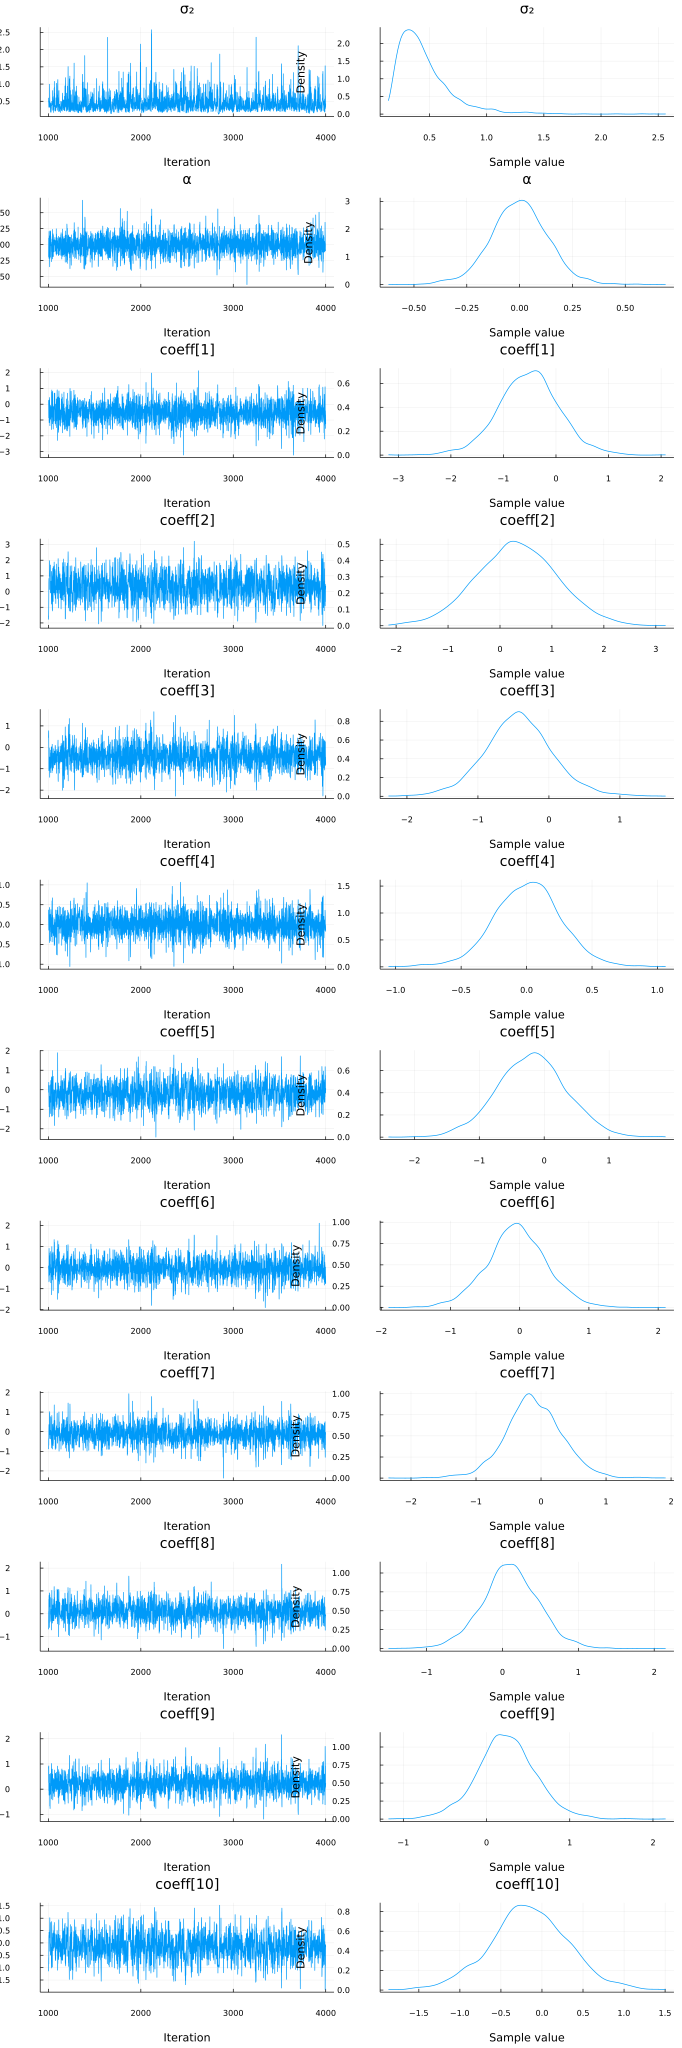

In [6]:
plot(chain)

In [7]:
Turing.describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (12 x 8)
 Quantiles (12 x 6)

In [9]:
# Comparing to OLS
# import GLM pkg
using GLM

# Perfomr OLS regression
train_with_intercept= hcat(ones(size(train, 1)), train)
ols= GLM.lm(train_with_intercept, train_target)

# Compute predictions on the training dataset
# and unstandardize them
p= GLM.predict(ols)
train_prediction_ols= μtargets .+ σtargets .* p

# Compute predictions on the test dataset and uinstandardize them
test_with_intercept= hcat(ones(size(test, 1)), test)
p= GLM.predict(ols, test_with_intercept)
test_prediction_ols= μtargets .+ σtargets .* p

10-element Vector{Float64}:
 26.80400291028905
 22.46687663424865
 20.566568257339053
 28.916865243164352
 11.584033637521244
 13.700618783530135
 27.46610606115152
 14.534616292183596
 17.289726316591185
 14.608379831235231

In [25]:
# Make a prediction given an input vector
function prediction(chain, x)
    p= Turing.get_params(chain[200:end, :, :])
    targets= p.α' .+ x * reduce(hcat, p.coeff)'
    return vec(mean(targets; dims=2))
end

prediction (generic function with 1 method)

In [27]:
# Calculate the predictions fior the training and testin sets and unstandardize them
p= prediction(chain, train)
train_prediction_bayes= μtargets .+ σtargets .*p
p= prediction(chain, test)
test_prediction_bayes= μtargets .+ σtargets .*p

10-element Vector{Float64}:
 26.79451885647756
 22.297385969408463
 20.41759498301655
 28.981981149369965
 11.616070447593318
 13.521345878574778
 27.25009443332604
 14.228162683535142
 17.178998868346994
 14.731571443404441

In [29]:
# Show the predictions on the test dataset
DataFrame(
    MPG= testset[:, target],
    Bayes= test_prediction_bayes,
    OLS= test_prediction_ols
    )

10×3 DataFrame
 Row │ MPG      Bayes    OLS     
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │    33.9  26.7945  26.804
   2 │    21.0  22.2974  22.4669
   3 │    21.4  20.4176  20.5666
   4 │    26.0  28.982   28.9169
   5 │    15.0  11.6161  11.584
   6 │    10.4  13.5213  13.7006
   7 │    30.4  27.2501  27.4661
   8 │    10.4  14.2282  14.5346
   9 │    18.7  17.179   17.2897
  10 │    17.3  14.7316  14.6084

In [31]:
# Lets evaluate the MSE
println(
    "Training set:",
    "\n\tBayes loss: ",
    Distances.msd(train_prediction_bayes, trainset[:, target]),
    "\n\tOLS loss: ",
    Distances.msd(train_prediction_ols, trainset[:, target])
    )

println(
    "Test set:",
    "\n\tBayes loss: ",
    Distances.msd(test_prediction_bayes, testset[:, target]),
    "\n\tOLS loss: ",
    Distances.msd(test_prediction_ols, testset[:, target])
    )


Training set:
	Bayes loss: 4.271954460300136
	OLS loss: 4.264328587912454
Test set:
	Bayes loss: 11.670918743990985
	OLS loss: 11.920700014054288
